In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from dac_analysis import get_df, to_results, value_counts
from dac_config import categories, groups, scale, agreement_cmap, red, orange, yellow, yellowgreen, lightgreen, green
from os import path as op
import matplotlib.pyplot as plt
import numpy as np


def plot(results, category_names, colors=None, limit=5., fname=None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    if colors is None:
        category_colors = plt.get_cmap("RdYlGn")(np.linspace(0.15, 0.85, data.shape[1]))
    else:
        category_colors = colors

    fig, ax = plt.subplots(figsize=(25, 5))
    #fig.suptitle("How much do you trust in these groups to act in the interest of society?", fontsize=16)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(
            labels,
            widths,
            left=starts,
            height=0.8,
            label=colname,
            color=color,
           # edgecolor="black",
        )
        ax.legend(loc="best", fontsize=24)
        # ax.set_xlabel(colname, fontsize = 20)
        xcenters = starts + widths / 2

        #r, g, b, _ = color
        text_color = "black"  # "white" if r * g * b < 0.5 else "darkgrey"
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > limit:
                ax.text(
                    x,
                    y,
                    "{:3.2f} %".format(c),
                    ha="center",
                    va="center",
                    color=text_color,
                    size=16,
                )

    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 1),
        loc="lower left",
        fontsize=18,  # "large",
    )

    ax.set_yticks(np.arange(len(labels)), labels=labels, size=16)

    if fname:
        fig.savefig(op.join("figs", fname), transparent=True, bbox_inches='tight')
    return fig, ax




In [35]:
df = get_df("data.csv", drop=False, translate=True)

shorts = {
    "DAC Awareness": "Haben Sie schon von Technologien zur Entnahme von Kohlendioxid (CO2) aus der Luft (auf Englisch Direct Air Capture (DAC)) gehört?",
    "DAC Knowledge": "Wie gut sind ihre Kenntnisse dieser Technologien?",
    "Storage Awareness": "Haben Sie schon von Kohlendioxid (CO2)-Speicherung gehört?",
    "Storage Knowledge": "Wie gut sind ihre Kenntnisse der CO2-Speicherungstechnologien?",
    "Initial Storage Support": "CO2-Speicherung",
    "Final Storage Support": "CO2-Speicherung.1",
    "Initial DAC Support": "Direct Air Capture (DAC)",
    "Final DAC Support": "Direct Air Capture (DAC).1",
}

DAC_KNOWLEDGE_DE = "Wie gut sind ihre Kenntnisse dieser Technologien?"
STORAGE_KNOWLEDGE_DE = "Wie gut sind ihre Kenntnisse der CO2-Speicherungstechnologien?"
DAC_KNOWLEDGE_EN = "How would you rate your knowledge of DAC?"
STORAGE_KNOWLEDGE_EN = "How would you rate your knowledge of CO2 Storage?"

labels = {
    DAC_KNOWLEDGE_DE: "Wie gut sind ihre Kenntnisse von Technologien\n zur Entnahme von Kohlendioxid (CO2) aus der Luft?",
    STORAGE_KNOWLEDGE_DE: "Wie gut sind ihre Kenntnisse\n der CO2-Speicherungstechnologien?",
    DAC_KNOWLEDGE_EN: "How would you rate your\n knowledge of DAC?",
    STORAGE_KNOWLEDGE_EN: "How would you rate your\n knowledge of CO2 Storage?",
}

DAC_KNOWLEDGE = DAC_KNOWLEDGE_EN
STORAGE_KNOWLEDGE = STORAGE_KNOWLEDGE_EN


# df = df[[DAC_KNOWLEDGE, STORAGE_KNOWLEDGE]]
df.loc[df[DAC_KNOWLEDGE].isnull(), DAC_KNOWLEDGE] = "Never heard"
df.loc[df[STORAGE_KNOWLEDGE].isnull(), STORAGE_KNOWLEDGE] = "Never heard"

knowledge = df[[DAC_KNOWLEDGE, STORAGE_KNOWLEDGE]]


category_names = categories["knowledge_en"]
counts = value_counts(knowledge)
results = to_results(counts, category_names, labels)

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

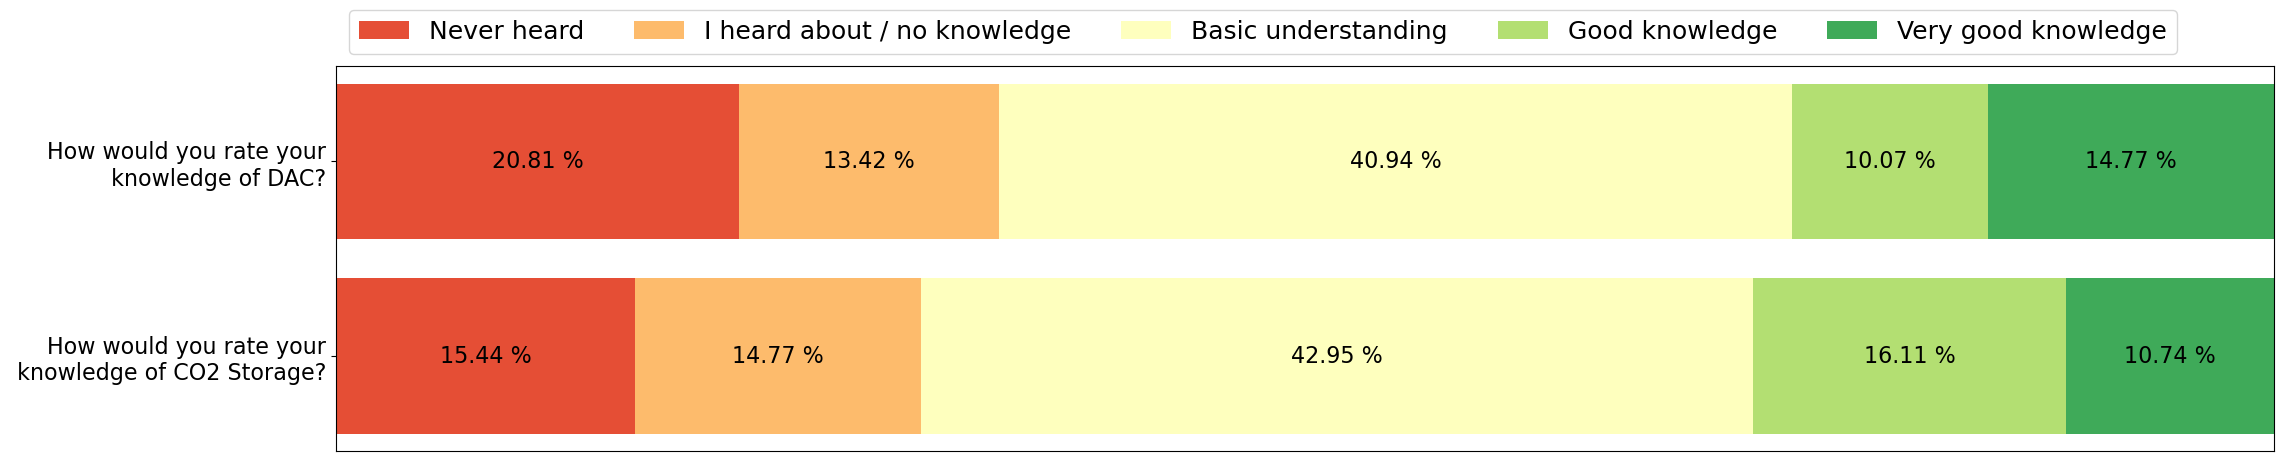

In [36]:
plot(results, category_names, fname="knowledge.png")

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

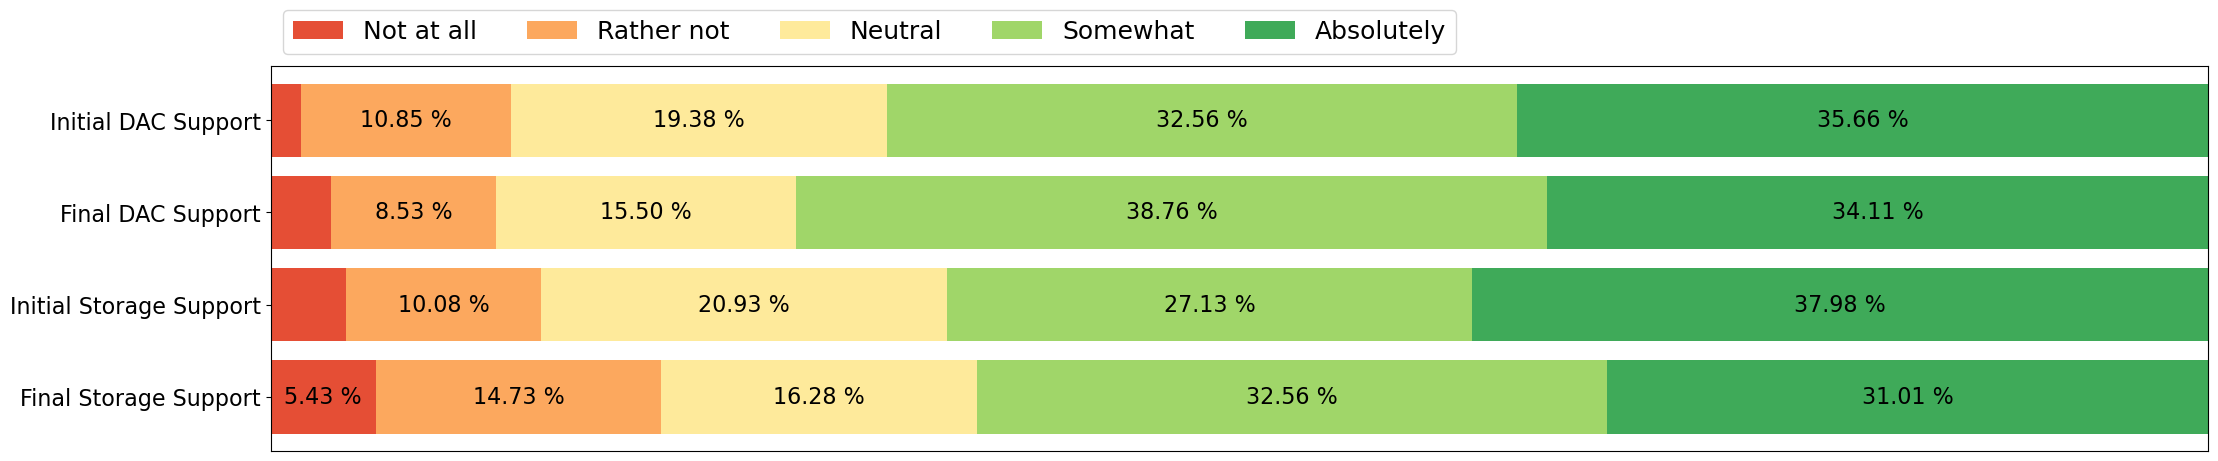

In [37]:
acceptance = [
    "Initial DAC Support",
    "Final DAC Support",
    "Initial Storage Support",
    "Final Storage Support"
]

acceptance = df[acceptance].dropna()

category_names = categories["support_en"]
counts = value_counts(acceptance)
results = to_results(counts, category_names, labels)

colors=["red", "orange", "lightyellow", "greenyellow", "limegreen"]
colors = [red, orange, yellow, lightgreen, green]

plot(results, category_names, colors=colors, fname="support.png")
#plt.show()

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

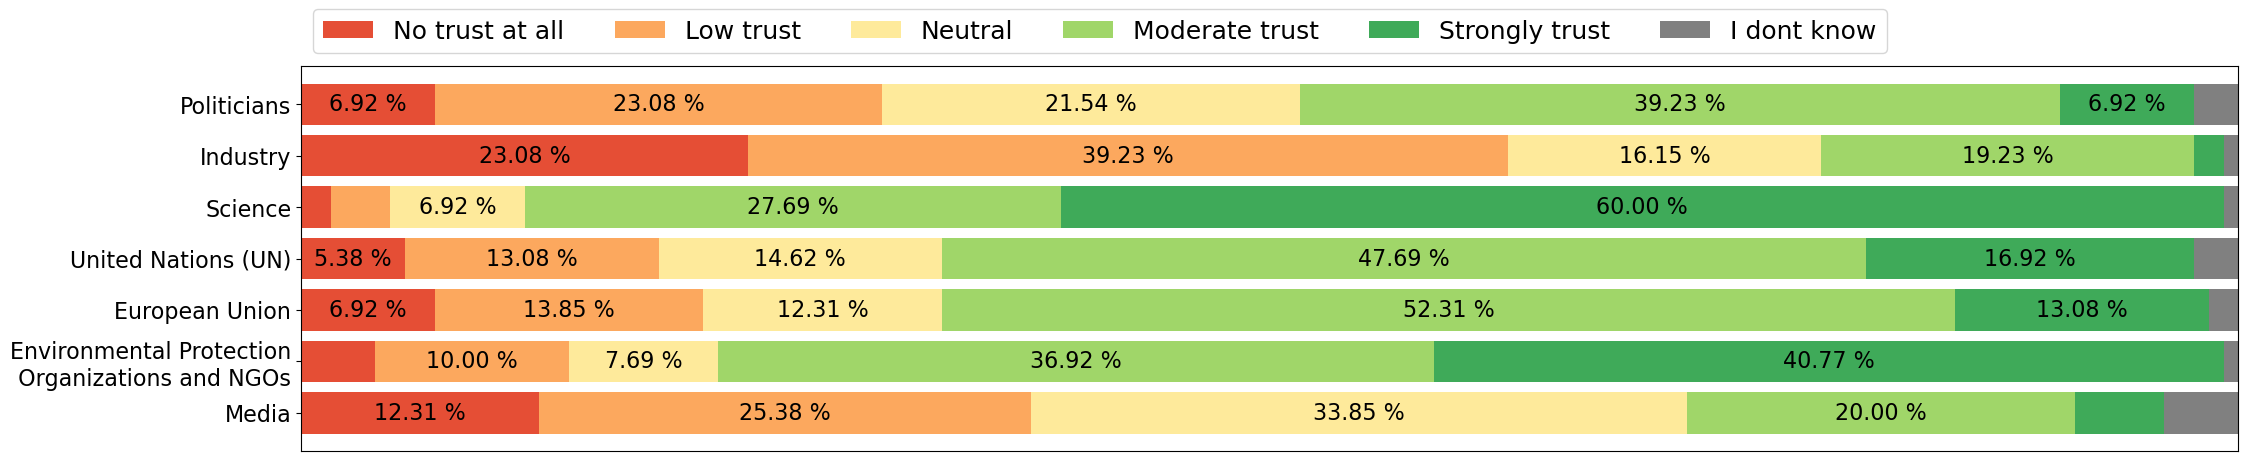

In [38]:
trust = [
    "Politicians",
    "Industry",
    "Science",
    "United Nations (UN)",
    "European Union",
    "Environmental Protection Organizations and NGOs",
    "Media",
]
trust = df[trust].dropna()

category_names = categories["trust_en"]
counts = value_counts(trust)
results = to_results(counts, category_names, labels={"Environmental Protection Organizations and NGOs":"Environmental Protection\n Organizations and NGOs"})

colors=["red", "orange", "lightyellow", "greenyellow", "limegreen", "gray"]
colors = agreement_cmap
plot(results, category_names, colors=colors, fname="trust.png")
#plt.show()

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

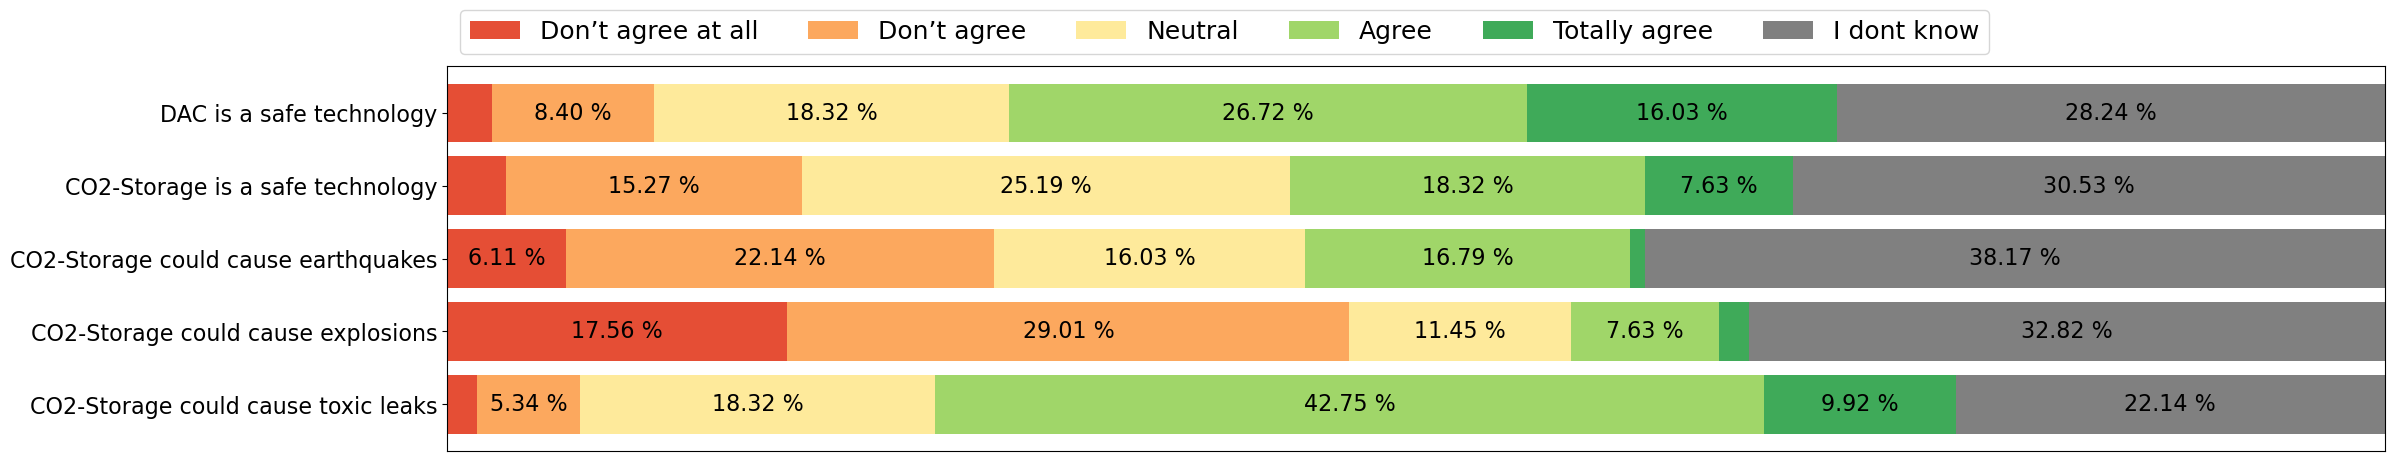

In [39]:
risk = [
    "DAC is a safe technology",
    "CO2-Storage is a safe technology",
    "CO2-Storage could cause earthquakes",
    "CO2-Storage could cause explosions",
    "CO2-Storage could cause toxic leaks",
]
risk = df[risk].dropna()

category_names = categories["agreement_en"]
counts = value_counts(risk)

results = to_results(counts, category_names)
plot(results, category_names, colors=agreement_cmap, fname="risk.png")

In [40]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

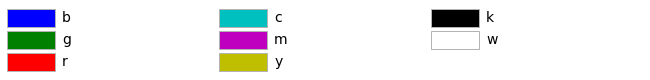

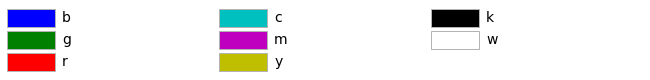

In [43]:
plot_colortable(mcolors.BASE_COLORS, ncols=3, sort_colors=False)

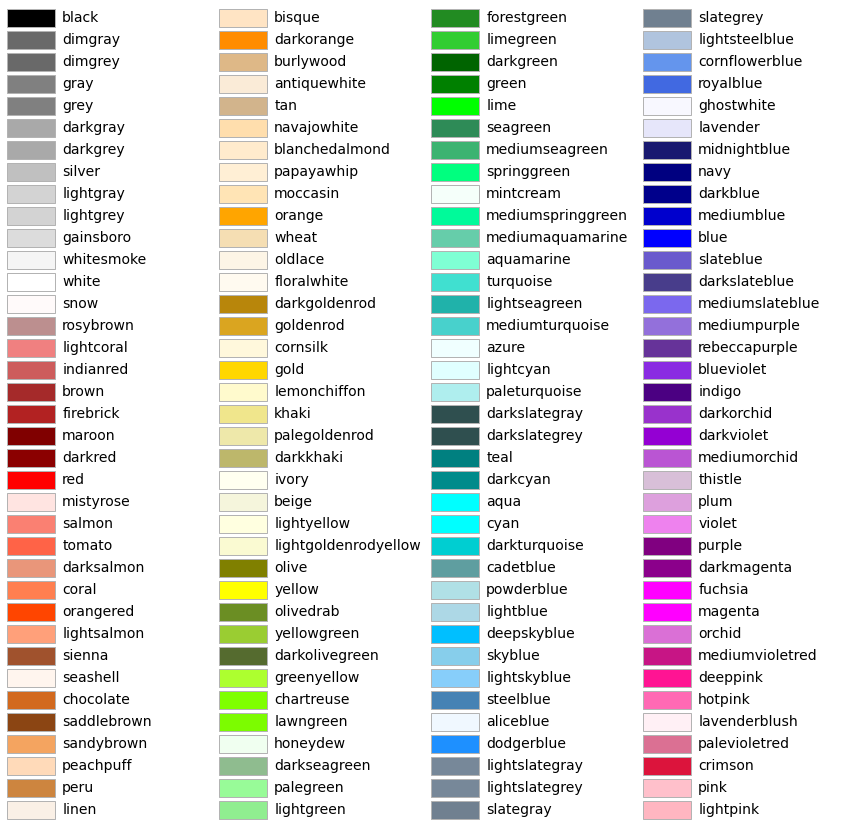

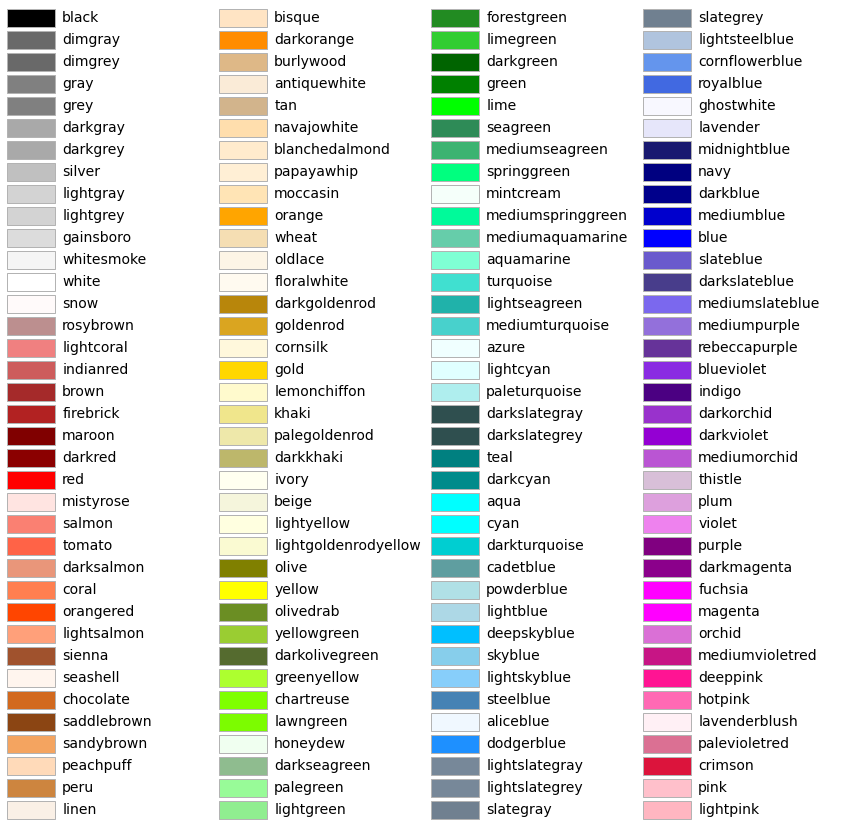

In [44]:
plot_colortable(mcolors.CSS4_COLORS)